In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import torch.distributions as td
from torch import optim
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer, SimpleImputer
from torchvision.datasets import MNIST
from torchvision import transforms

# Train a classifier on MNIST digits dataset


In [42]:
dataset_train = MNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
dataset_test = MNIST(root='./', train=False, download=True, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64, shuffle=False)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
def train_model(model, dataloader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    
    for epoch in range(epochs):
        for images, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
model = SimpleNN()
train_model(model, dataloader, epochs=5)
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
evaluate_model(model, dataloader_test)


Epoch [1/5], Loss: 0.0282
Epoch [2/5], Loss: 0.1437
Epoch [3/5], Loss: 0.0122
Epoch [4/5], Loss: 0.0116
Epoch [5/5], Loss: 0.1829
Accuracy of the model on the test set: 97.54%


In [2]:

dataset = MNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
x_data, y_data = dataset.data, dataset.targets

mask = (y_data <= 4)
x_data, y_data = x_data[mask], y_data[mask]

proportions = {0: 0.12, 1: 0.33, 2: 0.28, 3: 0.20, 4: 0.07}
num_samples = int(0.6 * len(y_data))
counts = {cls: int(proportions[cls] * num_samples) for cls in proportions}

bias_idx = []
remaining_idx = []

for cls in proportions:
    cls_idx = (y_data == cls).nonzero(as_tuple=True)[0]
    cls_idx = cls_idx[torch.randperm(len(cls_idx))]
    bias_cls_idx = cls_idx[:counts[cls]]
    remain_cls_idx = cls_idx[counts[cls]:]
    
    bias_idx.extend(bias_cls_idx.tolist())
    remaining_idx.extend(remain_cls_idx.tolist())

remaining_y = y_data[remaining_idx]
min_class_count = min([(remaining_y == cls).sum().item() for cls in proportions])

unbias_idx = []
for cls in proportions:
    cls_remaining_idx = (remaining_y == cls).nonzero(as_tuple=True)[0]
    cls_remaining_idx = cls_remaining_idx[torch.randperm(len(cls_remaining_idx))][:min_class_count]
    unbias_idx.extend([remaining_idx[i] for i in cls_remaining_idx])

bias = x_data[bias_idx]
bias_y = y_data[bias_idx]
unbias = x_data[unbias_idx]
unbias_y = y_data[unbias_idx]

bias.shape, bias_y.shape, unbias.shape, unbias_y.shape

(torch.Size([18353, 28, 28]),
 torch.Size([18353]),
 torch.Size([3425, 28, 28]),
 torch.Size([3425]))

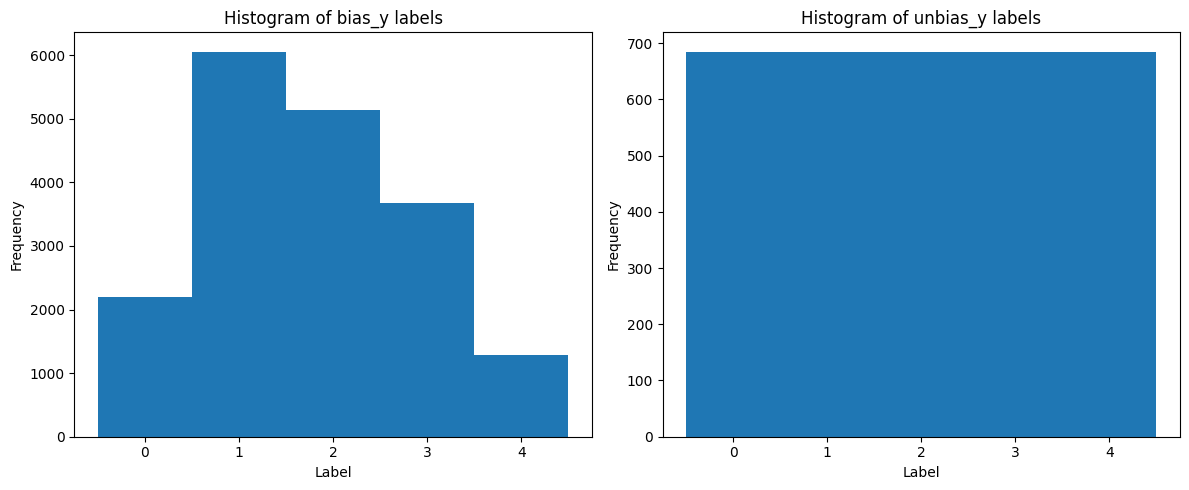

In [3]:
# Plot histograms in the same figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for bias_y
ax1.hist(bias_y, bins=np.arange(6) - 0.5)
ax1.set_xlabel('Label')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of bias_y labels')
ax1.set_xticks(range(5))

# Plot histogram for unbias_y
ax2.hist(unbias_y, bins=np.arange(6) - 0.5)
ax2.set_xlabel('Label')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of unbias_y labels')
ax2.set_xticks(range(5))

plt.tight_layout()
plt.show()


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 1024),
            nn.SiLU(),
            nn.Linear(1024, 512),
            nn.SiLU(),
            nn.Linear(512, 256),
            nn.SiLU(),
        )
        self.fc_mu = nn.Linear(256, 2)
        self.fc_logvar = nn.Linear(256, 2)
        self.decoder = nn.Sequential(
            nn.Linear(2, 256),
            nn.SiLU(),
            nn.Linear(256, 512),
            nn.SiLU(),
            nn.Linear(512, 1024),
            nn.SiLU(),
            nn.Linear(1024, 28*28),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_fn(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

batch_size = 128
bias_norm = bias.float().unsqueeze(1) / 255.
full_dataset = TensorDataset(bias_norm)

train_len = int(0.9 * len(full_dataset))
val_len = len(full_dataset) - train_len
train_set, val_set = random_split(full_dataset, [train_len, val_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

best_val_loss = float('inf')
patience = 5
patience_counter = 0
epochs = 100

epoch_iter = tqdm(range(epochs), desc="Training")
for epoch in epoch_iter:
    vae.train()
    train_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = loss_fn(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    vae.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            recon_x, mu, logvar = vae(x)
            loss = loss_fn(recon_x, x, mu, logvar)
            val_loss += loss.item()

    epoch_iter.set_postfix(train_loss=train_loss / len(train_loader.dataset),
                           val_loss=val_loss / len(val_loader.dataset))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = vae.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            break

vae.load_state_dict(best_state)
vae.to('cpu')

Training:  39%|███▉      | 39/100 [00:58<01:31,  1.50s/it, train_loss=120, val_loss=124]


VAE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1024, bias=True)
    (2): SiLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): SiLU()
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): SiLU()
  )
  (fc_mu): Linear(in_features=256, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): SiLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): SiLU()
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

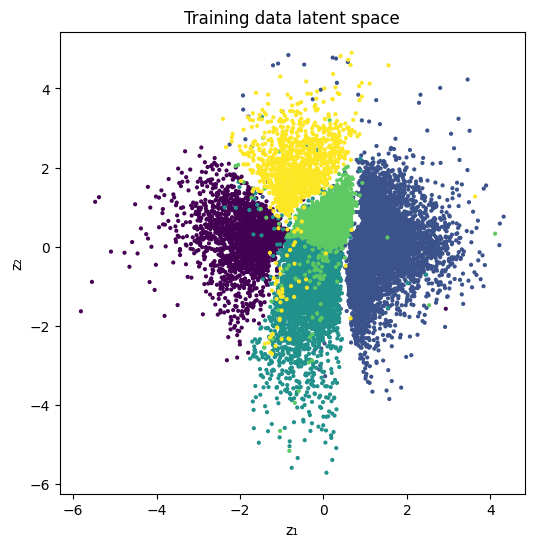

In [5]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

vae.to(device).eval()

dataset = TensorDataset(bias.float().unsqueeze(1) / 255., bias_y)
loader = DataLoader(dataset, batch_size=512, shuffle=False)

latents, labels = [], []
with torch.no_grad():
    for x, y in loader:
        mu, _ = vae.encode(x.to(device))
        latents.append(mu.cpu())
        labels.append(y)

z = torch.cat(latents).numpy()
lbl = torch.cat(labels).numpy()

plt.figure(figsize=(6, 6))
plt.scatter(z[:, 0], z[:, 1], c=lbl, s=4)
plt.xlabel('z₁')
plt.ylabel('z₂')
plt.title('Training data latent space')
plt.show()


/var/folders/j8/dm7qjtj55w3f6yvlj6rd2vx40000gn/T/ipykernel_59897/2506296876.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


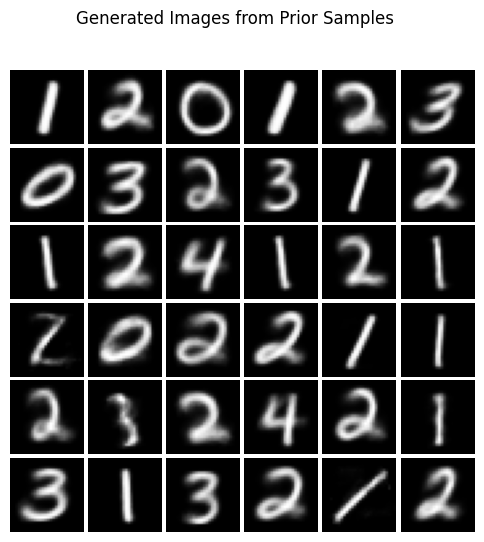

In [6]:
# Sample from the prior and decode to generate images
n_samples = 36
z_samples = torch.randn(n_samples, 2).to(device)  # Sample from standard normal prior and move to device

# Decode the samples
with torch.no_grad():
    generated_images = vae.decode(z_samples).cpu()

# Reshape images back to 28x28
generated_images = generated_images.view(n_samples, 28, 28)

# Plot in 6x6 grid
fig, axes = plt.subplots(6, 6, figsize=(6, 6), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
for i in range(6):
    for j in range(6):
        idx = i * 6 + j
        axes[i, j].imshow(generated_images[idx], cmap='gray')
        axes[i, j].axis('off')

plt.suptitle('Generated Images from Prior Samples')
plt.tight_layout()
plt.show()


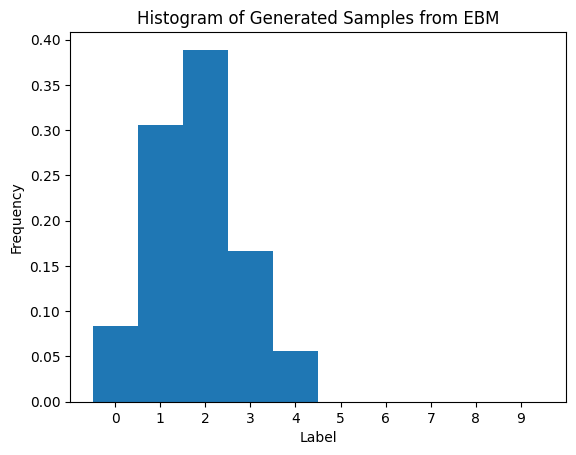

In [45]:
# Plot the histogram of the resulting samples :
class_decoded = model(generated_images.view(-1, 28 * 28))
class_decoded = class_decoded.argmax(dim=1).numpy()
plt.hist(class_decoded, bins=np.arange(11) - 0.5, density=True)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Histogram of Generated Samples from EBM')
plt.xticks(range(10))
plt.show()

## Train an EBM on the latent space

In [7]:
vae.to(device).eval()

unbias_dataset = TensorDataset(unbias.float().unsqueeze(1) / 255., unbias_y)
unbias_loader = DataLoader(unbias_dataset, batch_size=512, shuffle=False)

latents_unbias, images_unbias, labels_unbias = [], [], []
with torch.no_grad():
    for x, y in unbias_loader:
        mu, _ = vae.encode(x.to(device))
        latents_unbias.append(mu.cpu())
        images_unbias.append(x.cpu())
        labels_unbias.append(y.cpu())

latents_unbias = torch.cat(latents_unbias)
images_unbias = torch.cat(images_unbias)
labels_unbias = torch.cat(labels_unbias)

unbias_tensor_dataset = TensorDataset(latents_unbias, images_unbias, labels_unbias)

train_len = int(0.9 * len(unbias_tensor_dataset))
val_len = len(unbias_tensor_dataset) - train_len
train_ebm_set, val_ebm_set = random_split(unbias_tensor_dataset, [train_len, val_len])

train_ebm_loader = DataLoader(train_ebm_set, batch_size=128, shuffle=True)
val_ebm_loader = DataLoader(val_ebm_set, batch_size=128, shuffle=False)

In [8]:
###### Energy-Based Model Implementation ######
class SmallEBM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=256):
        super(SmallEBM, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze()

    def energy(self, x):
        return self.forward(x)

# # Initialize EBM
# ebm = SmallEBM().to(device)
# ebm_optimizer = optim.Adam(ebm.parameters(), lr=1e-3)


In [9]:
###### Energy-Based Model Training on Unbiased Latents ######
from tqdm import trange

ebm_epochs = 50
ebm = SmallEBM().to(device)
ebm_optimizer = optim.Adam(ebm.parameters(), lr=1e-3)

pbar = trange(ebm_epochs, desc="EBM Training")
for epoch in pbar:
    for latents, _, _ in train_ebm_loader:          # (z, x, y)
        batch = latents.to(device)

        # Positive energy
        pos_energy = ebm.energy(batch)

        # Negative samples ~ N(0, I)
        neg_samples = torch.randn_like(batch).to(device)
        neg_energy = ebm.energy(neg_samples)

        # Contrastive term
        loss = pos_energy.mean() - neg_energy.mean()

        # Energy norm regularization
        reg_loss = (pos_energy**2).mean() + (neg_energy**2).mean()

        # Gradient regularization
        interp = torch.rand(batch.size(0), 1, device=device)
        x_interp = (interp * batch + (1 - interp) * neg_samples).requires_grad_(True)
        energy_interp = ebm.energy(x_interp).mean()
        grad_interp = torch.autograd.grad(energy_interp, x_interp, create_graph=True)[0]
        grad_reg_loss = grad_interp.norm(2, dim=1).mean()

        # Total loss
        total_loss = loss + 0.15 * reg_loss + 0.15 * grad_reg_loss

        ebm_optimizer.zero_grad()
        total_loss.backward()
        ebm_optimizer.step()

    pbar.set_postfix(loss=total_loss.item(),
                     pos_energy=pos_energy.mean().item(),
                     neg_energy=neg_energy.mean().item())


EBM Training: 100%|██████████| 50/50 [00:02<00:00, 19.37it/s, loss=0.155, neg_energy=0.624, pos_energy=0.376]    


In [ ]:
###### Energy-weighted sampling from the standard normal prior ######
n_prior = 100000
with torch.no_grad():
    prior_samples = torch.randn(n_prior, 2).to(device)
    energies = ebm.energy(prior_samples)             # shape (n_prior,)
    weights = torch.softmax(-energies, dim=0)        # Boltzmann weights
    index_samples = torch.distributions.Categorical(weights).sample((1000,))
    ew_priors = prior_samples[index_samples]



/var/folders/j8/dm7qjtj55w3f6yvlj6rd2vx40000gn/T/ipykernel_59897/4245053289.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


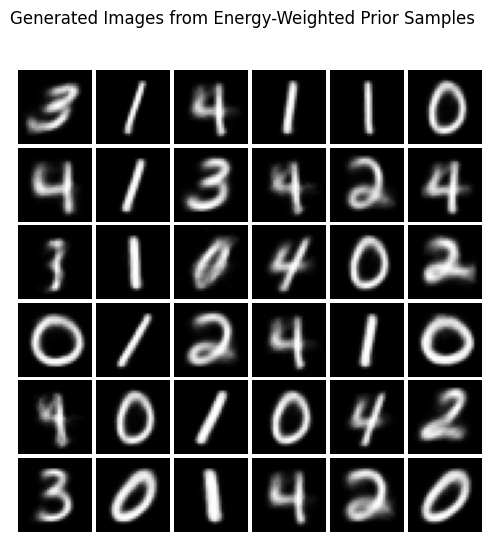

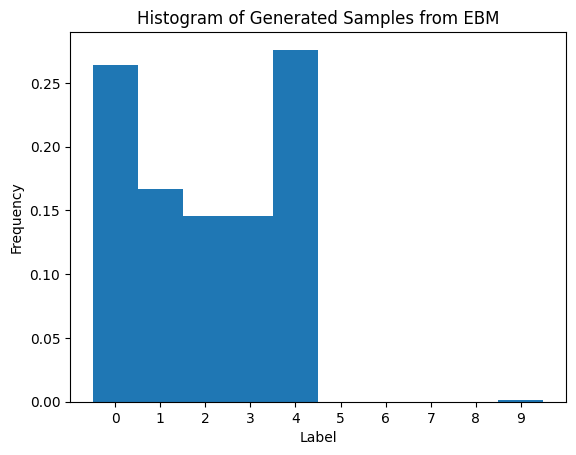

In [43]:
with torch.no_grad():
    decoded = vae.decode(ew_priors.to(device)).cpu().view(-1, 28, 28)

fig, axes = plt.subplots(6, 6, figsize=(6, 6), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
for i in range(6):
    for j in range(6):
        axes[i, j].imshow(decoded[i * 6 + j], cmap='gray')
        axes[i, j].axis('off')

plt.suptitle('Generated Images from Energy-Weighted Prior Samples')
plt.tight_layout()
plt.show()

# Plot the histogram of the resulting samples :
class_decoded = model(decoded.view(-1, 28 * 28))
class_decoded = class_decoded.argmax(dim=1).numpy()
plt.hist(class_decoded, bins=np.arange(11) - 0.5, density=True)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Histogram of Generated Samples from EBM')
plt.xticks(range(10))
plt.show()

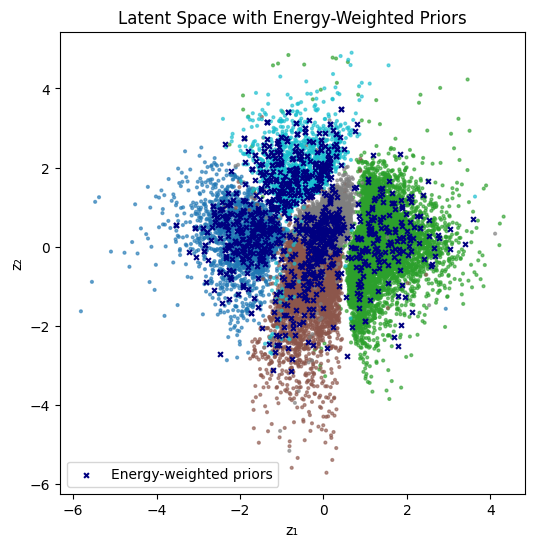

In [12]:
plt.figure(figsize=(6, 6))
plt.scatter(z[:, 0], z[:, 1], c=lbl, cmap='tab10', s=4, alpha=0.6)
# plt.scatter(prior_samples[:, 0].cpu(), prior_samples[:, 1].cpu(), c='lightgray', s=8, alpha=0.4, label='Prior samples')
plt.scatter(ew_priors[:, 0].cpu(), ew_priors[:, 1].cpu(), c='navy', s=12, marker='x', label='Energy-weighted priors')
plt.xlabel('z₁')
plt.ylabel('z₂')
plt.title('Latent Space with Energy-Weighted Priors')
plt.legend()
plt.show()


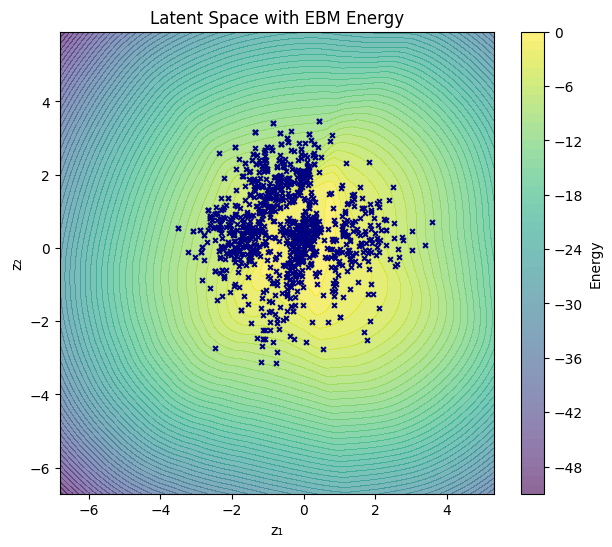

In [13]:
grid_res = 200
x_min, x_max = z[:, 0].min() - 1, z[:, 0].max() + 1
y_min, y_max = z[:, 1].min() - 1, z[:, 1].max() + 1
xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, grid_res),
                        torch.linspace(y_min, y_max, grid_res), indexing='xy')
grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)
with torch.no_grad():
    energy = ebm.energy(grid).cpu().view(grid_res, grid_res) + torch.distributions.Normal(0, 1).log_prob(grid).sum(dim=1).cpu().view(grid_res, grid_res)
plt.figure(figsize=(7, 6))
contour = plt.contourf(xx.cpu(), yy.cpu(), energy, levels=50, cmap='viridis', alpha=0.6)
plt.colorbar(contour, label='Energy')
# plt.scatter(z[:, 0], z[:, 1], c=lbl, cmap='tab10', s=4, alpha=0.6)
plt.scatter(ew_priors[:, 0].cpu(), ew_priors[:, 1].cpu(), c='navy', s=12, marker='x')
plt.xlabel('z₁')
plt.ylabel('z₂')
plt.title('Latent Space with EBM Energy')
plt.show()


# Doing SGLD

In [39]:
# Do SGLD on the resulting ebm:

def sgld_step(ebm, x, step_size=0.01, noise_std=0.1):
    x.requires_grad_(True)
    energy = -ebm.energy(x) + torch.distributions.Normal(0, 1).log_prob(x).sum(dim=1)
    grad = torch.autograd.grad(energy.sum(), x)[0]
    noise = torch.randn_like(x) * noise_std
    x_new = x + step_size * grad + noise
    return x_new.detach()

def sample_from_ebm(ebm, initial_samples, num_steps=1000, step_size=0.01, noise_std=0.1):
    samples = initial_samples.clone().detach()
    paths = [samples.clone().detach()]
    for i in range(num_steps):
        samples = sgld_step(ebm, samples, step_size, noise_std)
        # if i % 100 == 0:
        paths.append(samples.clone().detach())
    return paths


paths = sample_from_ebm(ebm, torch.distributions.Normal(0, 1).sample((64, 2)).to(device), num_steps=1000, step_size=0.01, noise_std=0.15)




/var/folders/j8/dm7qjtj55w3f6yvlj6rd2vx40000gn/T/ipykernel_59897/180345107.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


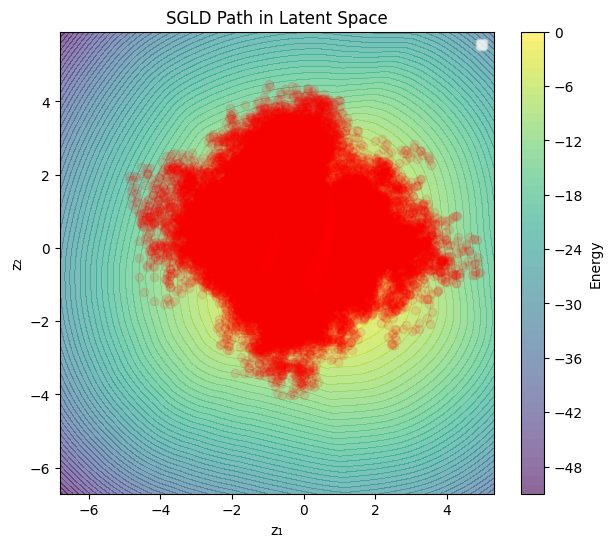

In [40]:
# Plot the path by 
plt.figure(figsize=(7, 6))
contour = plt.contourf(xx.cpu(), yy.cpu(), energy, levels=50, cmap='viridis', alpha=0.6)
plt.colorbar(contour, label='Energy')
# plt.scatter(ew_priors[:, 0].cpu(), ew_priors[:, 1].cpu(), c='navy', s=12, marker='x', label='Energy-weighted priors')

for path in paths:
    plt.scatter(path[:, 0].cpu(), path[:, 1].cpu(), color='red', alpha=0.1)

plt.xlabel('z₁')
plt.ylabel('z₂')
plt.title('SGLD Path in Latent Space')
plt.legend()
plt.show()
# Save the trained EBM model

/var/folders/j8/dm7qjtj55w3f6yvlj6rd2vx40000gn/T/ipykernel_59897/38332732.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


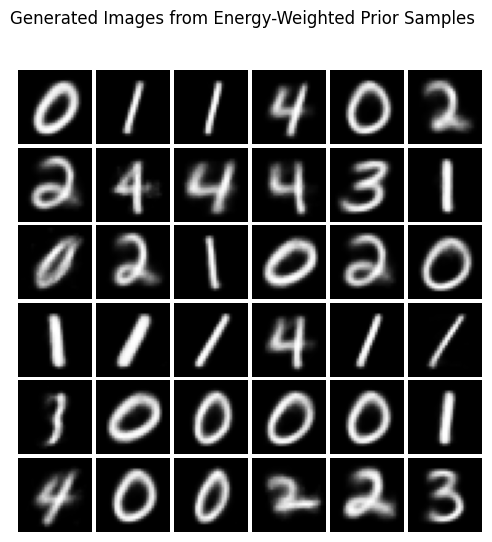

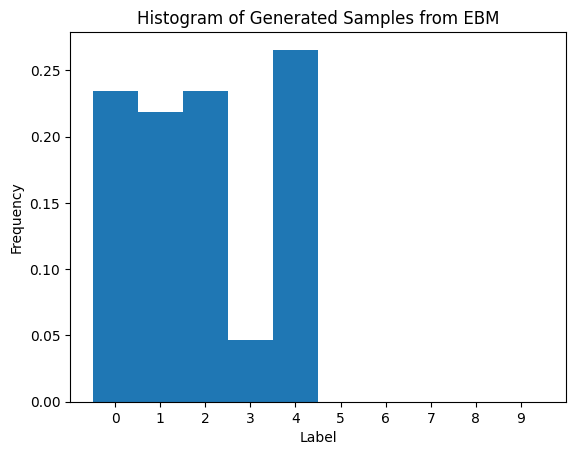

In [44]:
with torch.no_grad():
    decoded = vae.decode(paths[-1].to(device)).cpu().view(-1, 28, 28)

fig, axes = plt.subplots(6, 6, figsize=(6, 6), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
for i in range(6):
    for j in range(6):
        axes[i, j].imshow(decoded[i * 6 + j], cmap='gray')
        axes[i, j].axis('off')

plt.suptitle('Generated Images from Energy-Weighted Prior Samples')
plt.tight_layout()
plt.show()


# Plot the histogram of the resulting samples :
class_decoded = model(decoded.view(-1, 28 * 28))
class_decoded = class_decoded.argmax(dim=1).numpy()
plt.hist(class_decoded, bins=np.arange(11) - 0.5, density=True)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Histogram of Generated Samples from EBM')
plt.xticks(range(10))
plt.show()